In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
warnings.filterwarnings(action='ignore')


    survival          생존 여부            0 = No, 1 = Yes

    pclass            선실 등급            1 = 1st, 2 = 2nd, 3 = 3rd

    sex               성별    

    Age               나이  

    sibsp             형재 자매의 수/ 배우자 등이 승선한 경우 수    

    parch             부모나 자식과 같이 탄 경우 수   

    ticket            표 번호    

    fare              요금

    cabin             선실 번호   

    embarked          승선한 항구         C = Cherbourg, Q = Queenstown, S = Southampton


******역사적 배경 1912년 미국 가는 배 ?


point . 나이 범주화 또는  mr , mrs , name 를 이용한 age 결측치 채우기 

2. (1,2,3 등 칸 )
3. 아이 우선 기준 13세 이하 ? -> 나이를 이용한 생존율 예측 -> linear regressioin
 - > age group heatmap


In [2]:
test_csv = pd.read_csv('/Users/chosunghyun/Desktop/Python.proj/kaggle/Titanic/test.csv')
train_csv = pd.read_csv('/Users/chosunghyun/Desktop/Python.proj/kaggle/Titanic/train.csv')

In [3]:
test_csv.info()
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass  

In [4]:
train_data = train_csv.copy()
test_data = test_csv.copy()

In [5]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [7]:
# 전제 조건  : 성별과 생존율 , 계급과 생존율은 연관이 있다.  -> 종속이다 독립이 아니다.

In [8]:
tddf = train_data[['Survived','Pclass']]

f = tddf.loc[(tddf['Pclass'] == 1)]
s = tddf.loc[(tddf['Pclass'] == 2)]
t = tddf.loc[(tddf['Pclass'] == 3)]

def survived(seriess):
    s =0
    d =0
    for x in seriess :
        if x == 1:
            s+=1
        else: d+=1

    result= s/(s+d)
    return result


print(survived(f.Survived),survived(s.Survived),survived(t.Survived))

# train data set first class 가 3배 높은 생존율을 보임


0.6296296296296297 0.47282608695652173 0.24236252545824846


In [9]:
#train_data['Sex'].isnull().sum()   :  0
train_data['Sex']

0        male
1      female
2      female
3      female
4        male
        ...  
886      male
887    female
888    female
889      male
890      male
Name: Sex, Length: 891, dtype: object

In [10]:
###  성별 생존율  ,결측치 없음
tddf = train_data[['Survived','Sex']]
f = tddf.loc[(tddf['Sex'] == 'female')]
m = tddf.loc[(tddf['Sex'] == 'male')]
print(survived(f.Survived),survived(m.Survived))

0.7420382165605095 0.18890814558058924


In [11]:
# 전제 조건 점검
# data  수 -> 중심극한 정리 n >30 정규성을 만족
# 상관 관계 파악
cor = train_data.corr()
cor

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


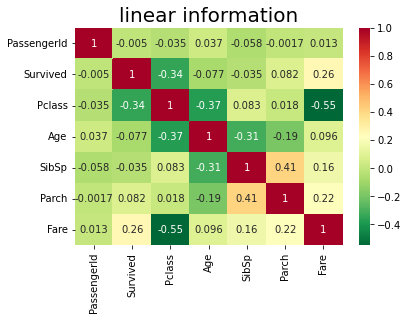

In [12]:
# correlation by features -> linear information

sns.heatmap(cor, annot=True,cmap='RdYlGn_r')
plt.title('linear information',fontsize =20)
plt.show()

In [13]:
# traindata,testdata 의 NAN를 채운다 - >fare  -  class

In [14]:
trddf = train_data[['Pclass','Fare']]
teddf = test_data[['PassengerId','Pclass','Fare']]

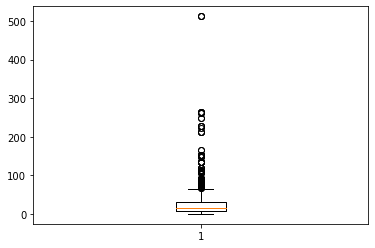

In [15]:
ax = plt.boxplot(train_data[['Fare']])
plt.show()

In [16]:
trddf['Fare'].max()

512.3292

In [17]:
f = trddf.loc[(trddf['Pclass'] == 1)]
s = trddf.loc[(trddf['Pclass'] == 2)]
t = trddf.loc[(trddf['Pclass'] == 3)]

In [18]:
print(len(f),len(s),len(t))

216 184 491


In [19]:
print(f.Fare.mean())
print(s.Fare.mean())
print(t.Fare.mean())

84.15468749999992
20.66218315217391
13.675550101832997


In [20]:
# 행 추출
teddf[teddf['Fare'].isnull()]

,PassengerId,Pclass,Fare
152,1044,3,NaN


In [21]:
# 결측치 처리 및 확인 
test_data.loc[(test_data['PassengerId']==1044),'Fare'] = 13 

In [22]:
teddf = test_data[['PassengerId','Pclass','Fare']]
teddf[teddf['Fare'].isnull()]

,PassengerId,Pclass,Fare


# Age - Name  - 생존율 ?


-> mr,miss,,,,etc


-> mean

-> SibSp,Parch

--> 어린 아이의 under 14 생존율이 높을듯,,하다!     -> same cabin ?

In [23]:
train_data.Name

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [24]:
trdf = train_data[['Age','Survived']]
# 나이 평균으로 결측 채우기
meanAge = trdf.Age.mean()
meanAge = round(meanAge,3)
meanAge

29.699

In [25]:
trdf.Age=trdf.Age.fillna(meanAge)     

In [26]:
trdf.isnull().sum()

Age         0
Survived    0
dtype: int64

In [27]:
o = trdf.loc[(trdf['Age'] > 13)]
y = trdf.loc[(trdf['Age'] <= 13)]

def survived(seriess):
    s =0
    d =0
    for x in seriess :
        if x == 1:
            s+=1
        else: d+=1

    result= s/(s+d)
    return result


print(round(survived(o.Survived),3),round(survived(y.Survived),3))

print("생존율 차이:",round(survived(y.Survived),3)/round(survived(o.Survived),3))

# 13 이하 이면 확률이 현저히 높다 -> 그럼 몇살까지? ,성별 영향 ? , null 값이 평균이 아니 라면


0.366 0.592
생존율 차이: 1.6174863387978142


Name


In [28]:
# Name ,FirstName ,  Mr,Mis etc
trname = train_data[['Name','Survived']]
temp = trname.Name[0]
print(temp)
#print(trname.Name.value_counts())

Braund, Mr. Owen Harris


In [29]:
print(temp.split())
tmpname =temp.split()

['Braund,', 'Mr.', 'Owen', 'Harris']


In [30]:
print(tmpname[1])

Mr.


In [31]:
trname['NameTag'] = 'Mr'
trname['FirstName'] = 'Cho'

In [32]:
trname

,Name,Survived,NameTag,FirstName
0,"Braund, Mr. Owen Harris",0,Mr,Cho
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,Mr,Cho
2,"Heikkinen, Miss. Laina",1,Mr,Cho
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,Mr,Cho
4,"Allen, Mr. William Henry",0,Mr,Cho
...,...,...,...,...
886,"Montvila, Rev. Juozas",0,Mr,Cho
887,"Graham, Miss. Margaret Edith",1,Mr,Cho
888,"Johnston, Miss. Catherine Helen ""Carrie""",0,Mr,Cho
889,"Behr, Mr. Karl Howell",1,Mr,Cho


In [33]:
# 분리 함수 

def NameCut(seriess,df):
    cnt = 0 
    for nameg in seriess :
        namesplit = nameg.split()
        df['FirstName'][cnt]=namesplit[0]        
        df['NameTag'][cnt]=namesplit[1]
        cnt+=1

NameCut(trname.Name,trname)
trname

,Name,Survived,NameTag,FirstName
0,"Braund, Mr. Owen Harris",0,Mr.,"Braund,"
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,Mrs.,"Cumings,"
2,"Heikkinen, Miss. Laina",1,Miss.,"Heikkinen,"
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,Mrs.,"Futrelle,"
4,"Allen, Mr. William Henry",0,Mr.,"Allen,"
...,...,...,...,...
886,"Montvila, Rev. Juozas",0,Rev.,"Montvila,"
887,"Graham, Miss. Margaret Edith",1,Miss.,"Graham,"
888,"Johnston, Miss. Catherine Helen ""Carrie""",0,Miss.,"Johnston,"
889,"Behr, Mr. Karl Howell",1,Mr.,"Behr,"


In [34]:
# 적용 확인후 원본 데이터에도 적용
train_data['NameTag'] = 'Mr'
test_data['NameTag'] = 'Mr'
train_data['FirstName'] = 'Cho'
test_data['FirstName'] = 'Cho'
NameCut(train_data.Name,train_data)
NameCut(test_data.Name,test_data)
train_data['NameTag']

0        Mr.
1       Mrs.
2      Miss.
3       Mrs.
4        Mr.
       ...  
886     Rev.
887    Miss.
888    Miss.
889      Mr.
890      Mr.
Name: NameTag, Length: 891, dtype: object

In [37]:
print(train_data.Age.isnull().sum())
print(test_data.Age.isnull().sum())

177
86


## algo age

1. Nametag -sex ,  mean age  이용 -> test, train. tag value 비교.  같으면 채우기, 다르면 보류
* 직업 군들을 나눌수 있다.

2. FirstName, sex ,Cabin, Sbsp,parch 가족 유추 -> age update    -> test , train   
* 어린이 찾기!


3. etc : 독신 가족 x ,특이한 tag , 1, 2  -> 탑승지,pclass - 나이 유추 -> 경재적 상황


In [43]:
tragename=train_data[['NameTag','FirstName','Survived','Sex','Cabin','Age']]
teagename=test_data[['NameTag','FirstName','Sex','Cabin','Age']]

In [45]:
#pd.crosstab(tragename.NameTag, agename.Sex).T.style.background_gradient(cmap='summer_r')
pd.crosstab(teagename.NameTag, agename.Sex).T.style.background_gradient(cmap='summer_r')

NameTag,"Billiard,","Brito,","Carlo,",Col.,Dr.,"Khalil,",Master.,"Messemaeker,",Miss.,Mr.,Mrs.,Ms.,"Palmquist,","Planke,",Rev.,y
Sex,,,,,,,,,,,,,,,,
female,1,0,1,0,1,1,5,0,26,94,29,1,0,0,0,1
male,1,1,0,2,0,0,14,1,51,140,41,0,1,1,2,3


In [41]:
pd.crosstab(agename.FirstName, agename.Sex).T.style.background_gradient(cmap='summer_r')

FirstName,"Abbing,","Abbott,","Abelson,","Adahl,","Adams,","Ahlin,","Aks,","Albimona,","Alexander,","Alhomaki,","Ali,","Allen,","Allison,","Allum,","Andersen-Jensen,","Anderson,","Andersson,","Andreasson,","Andrew,","Andrews,","Angle,","Appleton,","Arnold-Franchi,","Artagaveytia,","Asim,","Asplund,","Astor,","Attalah,","Aubart,","Augustsson,","Ayoub,","Backstrom,","Baclini,","Badt,","Bailey,","Balkic,","Ball,","Banfield,","Barah,","Barbara,","Barber,","Barkworth,","Barton,","Bateman,","Baumann,","Baxter,","Bazzani,","Beane,","Beavan,","Becker,","Beckwith,","Beesley,","Behr,","Bengtsson,","Berglund,","Berriman,","Betros,","Bidois,","Bing,","Birkeland,","Bishop,","Bissette,","Bjornstrom-Steffansson,","Blackwell,","Blank,","Bonnell,","Bostandyeff,","Boulos,","Bourke,","Bowen,","Bowerman,","Bracken,","Bradley,","Braund,","Brewe,","Brocklebank,","Brown,","Bryhl,","Burke,","Burns,","Buss,","Butler,","Butt,","Byles,","Bystrom,","Cacic,","Cairns,","Calderhead,","Caldwell,","Calic,","Cameron,","Campbell,","Canavan,","Cann,","Caram,","Carbines,","Cardeza,","Carlsson,","Carr,","Carrau,","Carter,","Cavendish,","Celotti,","Chaffee,","Chambers,","Chapman,","Charters,","Cherry,","Chibnall,","Chip,","Christmann,","Christy,","Chronopoulos,","Clarke,","Cleaver,","Clifford,","Coelho,","Cohen,","Coleff,","Coleridge,","Collander,","Colley,","Collyer,","Compton,","Connaghton,","Connolly,","Connors,","Cook,","Cor,","Corn,","Coutts,","Coxon,","Crease,","Cribb,","Crosby,","Culumovic,","Cumings,","Cunningham,","Dahl,","Dahlberg,","Dakic,","Daly,","Danbom,","Daniel,","Danoff,","Dantcheff,","Davidson,","Davies,","Davis,","Davison,","Dean,","Denkoff,","Dennis,","Devaney,","Dick,","Dimic,","Dodge,","Doharr,","Doling,","Dooley,","Dorking,","Douglas,","Dowdell,","Downton,","Drazenoic,","Drew,","Duane,",Duff,Duran,"Edvardsson,","Eitemiller,","Eklund,","Ekstrom,","Elias,","Elsbury,","Emanuel,","Emir,","Endres,","Eustis,","Fahlstrom,","Farrell,","Farthing,","Faunthorpe,","Fischer,","Fleming,","Flynn,","Foo,","Ford,","Foreman,","Fortune,","Fox,","Francatelli,","Frauenthal,","Frolicher,","Frolicher-Stehli,","Frost,","Fry,","Funk,","Futrelle,","Fynney,","Gale,","Gallagher,","Garfirth,","Garside,","Gaskell,","Gavey,","Gee,","Gheorgheff,","Giglio,","Giles,","Gilinski,","Gill,","Gillespie,","Gilnagh,","Givard,","Glynn,","Goldenberg,","Goldschmidt,","Goldsmith,","Goncalves,","Goodwin,","Graham,","Green,","Greenberg,","Greenfield,","Gronnestad,","Guggenheim,","Gustafsson,","Haas,","Hagland,","Hakkarainen,","Hale,","Hamalainen,","Hampe,","Hanna,","Hansen,","Harder,","Harknett,","Harmer,","Harper,","Harrington,","Harris,","Harrison,","Hart,","Hassab,","Hassan,","Hawksford,","Hays,","Healy,","Hedman,","Hegarty,","Heikkinen,","Heininen,","Hendekovic,","Henry,","Herman,","Hewlett,","Hickman,","Hippach,","Hirvonen,","Hocking,","Hodges,","Hogeboom,","Hold,","Holm,","Holverson,","Homer,","Honkanen,","Hood,","Horgan,","Hosono,","Hoyt,","Humblen,","Hunt,",Ibrahim,"Icard,","Ilett,","Ilmakangas,","Isham,","Ivanoff,","Jacobsohn,","Jalsevac,","Jansson,","Jardin,","Jarvis,","Jenkin,","Jensen,","Jermyn,","Jerwan,","Johannesen-Bratthammer,","Johanson,","Johansson,","Johnson,","Johnston,","Jonkoff,","Jonsson,","Jussila,","Kallio,","Kalvik,","Kantor,","Karaic,","Karlsson,","Karun,","Kassem,","Keane,","Keefe,","Kelly,","Kent,","Kenyon,","Kiernan,","Kilgannon,","Kimball,","Kink,","Kink-Heilmann,","Kirkland,","Klaber,","Klasen,","Knight,","Kraeff,","Kvillner,","Lahoud,","Lahtinen,","Laitinen,","Laleff,","Lam,","Landergren,","Lang,","Laroche,","Larsson,","LeRoy,","Leader,","Leeni,","Lefebre,","Lehmann,","Leinonen,","Leitch,","Lemberopolous,","Lemore,","Lennon,","Leonard,","Lester,","Lesurer,","Levy,","Lewy,","Leyson,","Lievens,","Lindahl,","Lindblom,","Lindell,","Lindqvist,","Lines,","Ling,","Lobb,","Long,","Longley,","Louch,","Lovell,","Lulic,","Lundahl,","Lurette,","Mack,","Madigan,","Madill,","Madsen,","Maenpaa,","Maioni,","Maisner,","Mallet,","Mamee,","Mangan,","Mannion,","Marechal,","Ma

In [48]:
def survratio(col):
    return train_data.groupby(col)['Survived'].mean()
survratio('NameTag')

NameTag
Billiard,       0.000000
Capt.           0.000000
Carlo,          0.000000
Col.            0.500000
Cruyssen,       0.000000
Don.            0.000000
Dr.             0.428571
Gordon,         1.000000
Impe,           0.000000
Jonkheer.       0.000000
Major.          0.500000
Master.         0.575000
Melkebeke,      0.000000
Messemaeker,    1.000000
Miss.           0.703911
Mlle.           1.000000
Mme.            1.000000
Mr.             0.157371
Mrs.            0.801653
Ms.             1.000000
Mulder,         1.000000
Pelsmaeker,     0.000000
Planke,         0.000000
Rev.            0.000000
Shawah,         0.000000
Steen,          0.000000
Velde,          0.000000
Walle,          0.000000
der             0.000000
the             1.000000
y               0.750000
Name: Survived, dtype: float64

In [56]:
train_data['Age'] = train_data.groupby('NameTag')['Age'].apply(lambda x: x.fillna(x.mean()))
test_data['Age'] = test_data.groupby('NameTag')['Age'].apply(lambda x: x.fillna(x.mean()))

In [57]:
print(train_data.Age.isnull().sum())
print(test_data.Age.isnull().sum())

1
1


In [59]:
# 행추출 null in age
train_data[train_data['Age'].isnull()]       
#get data from Mr mean

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NameTag,FirstName
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5,NaN,S,"Melkebeke,",van


In [60]:
test_data[test_data['Age'].isnull()]
# get number from train data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NameTag,FirstName
88,980,3,"O'Donoghue, Ms. Bridget",female,NaN,0,0,364856,7.75,NaN,Q,Ms.,"O'Donoghue,"


정보 수정

In [68]:
train_data.groupby('NameTag').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
NameTag,,,,,,,
"Billiard,",154.000000,0.000000,3.000000,40.500000,0.000000,2.000000,14.500000
Capt.,746.000000,0.000000,1.000000,70.000000,1.000000,1.000000,71.000000
"Carlo,",362.000000,0.000000,2.000000,29.000000,1.000000,0.000000,27.720800
Col.,671.500000,0.500000,1.000000,58.000000,0.000000,0.000000,31.025000
"Cruyssen,",874.000000,0.000000,3.000000,47.000000,0.000000,0.000000,9.000000
Don.,31.000000,0.000000,1.000000,40.000000,0.000000,0.000000,27.720800
Dr.,545.857143,0.428571,1.285714,42.000000,0.571429,0.000000,49.168457
"Gordon,",578.500000,1.000000,1.000000,48.500000,1.000000,0.000000,48.264600
"Impe,",605.333333,0.000000,3.000000,25.333333,0.666667,1.333333,24.150000


In [69]:
train_data['Age'] = train_data['Age'].fillna(32)

In [70]:
test_data.groupby('NameTag').mean()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
NameTag,,,,,,
"Billiard,",1160.000000,3.000000,11.500000,1.000000,1.000000,14.500000
"Brito,",1228.000000,2.000000,32.000000,0.000000,0.000000,13.000000
"Carlo,",907.000000,2.000000,24.000000,1.000000,0.000000,27.720800
Col.,1058.500000,1.000000,50.000000,0.500000,0.000000,128.012500
Dr.,1185.000000,1.000000,53.000000,1.000000,1.000000,81.858300
"Khalil,",911.000000,3.000000,45.000000,0.000000,0.000000,7.225000
Master.,1119.526316,2.684211,7.150625,1.631579,1.421053,41.019732
"Messemaeker,",1152.000000,3.000000,36.500000,1.000000,0.000000,17.400000
Miss.,1101.649351,2.441558,21.644286,0.545455,0.402597,40.428519


In [71]:
# train data 이용
test_data['Age'] = test_data['Age'].fillna(28)

In [73]:
print(train_data.Age.isnull().sum())
print(test_data.Age.isnull().sum())

0
0


 baby?

##   Age  -surv
##   Age  pclass - surv
##   Age pclass - sex - surv  

Age
1.continus 2.catagorical